# 5. CNN-LSTM

이전 4장에서는 LSTM을 활용하여 대한민국 코로나19 확진자 수를 예측해보았습니다. LSTM은 [Hochreiter & Schmidhuber (1997)](http://www.bioinf.jku.at/publications/older/2604.pdf)에 의해 처음 소개되었고, 이후 지속적인 연구와 함께 발전해오고 있습니다.

이번 장에서는 모델 성능 향상을 위한 다른 방법을 실험해보도록 하겠습니다. 모델 성능 향상을 위해서는 배치 (batch) 사이즈와 에폭 (epoch) 수 변경, 데이터셋 큐레이팅(Dataset Curating), 데이터셋 비율 조정, 손실 함수(Loss Function) 변경, 모델 변경 등의 방법이 있지만, 이번 실습에서는 모델 구조 변경을 통해 성능을 향상을 진행해보겠습니다. CNN-LSTM 모델을 사용하여, 대한민국 코로나19 확진자 수 예측에 있어서 더 나은 성능을 보일 수 있는지 살펴보도록 하겠습니다.

가장 먼저 이번 장에 필요한 라이브러리들을 불러오도록 하겠습니다. 가장 기본적인 `torch`, `numpy`, `pandas`와, 프로세스 상태를 표시하는 `tqdm`, 시각화 라이브러리인 `pylab`, `matplotlib` 등을 사용하겠습니다.

In [1]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## 5.1 데이터셋 다운로드 및 전처리


모델링 실습을 위해 대한민국 코로나 누적 확진자 
데이터를 불러오겠습니다. 2.1절에 나온 코드를 활용하겠습니다. 

In [2]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data COVIDTimeSeries
!unzip -q COVIDTimeSeries.zip

fatal: destination path 'Tutorial-Book-Utils' already exists and is not an empty directory.


COVIDTimeSeries.zip is done!


'unzip'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


`pandas` 라이브러리를 이용하여 코로나 확진자 데이터를 불러온 후 3장에서 실습한 데이터 전처리를 실시하겠습니다. 데이터셋 기간은 2020년 1월 22일 부터 2020년 12월 18일 입니다.

In [3]:
confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed[confirmed['Country/Region']=='Korea, South']
korea = confirmed[confirmed['Country/Region']=='Korea, South'].iloc[:,4:].T
korea.index = pd.to_datetime(korea.index)
daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int')


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5
X, y = create_sequences(daily_cases, seq_length)

#학습용, 검증용, 시험용으로 분리
train_size = int(327 * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

#MinMax 스케일링
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

#Tensor 형태로 변환
def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

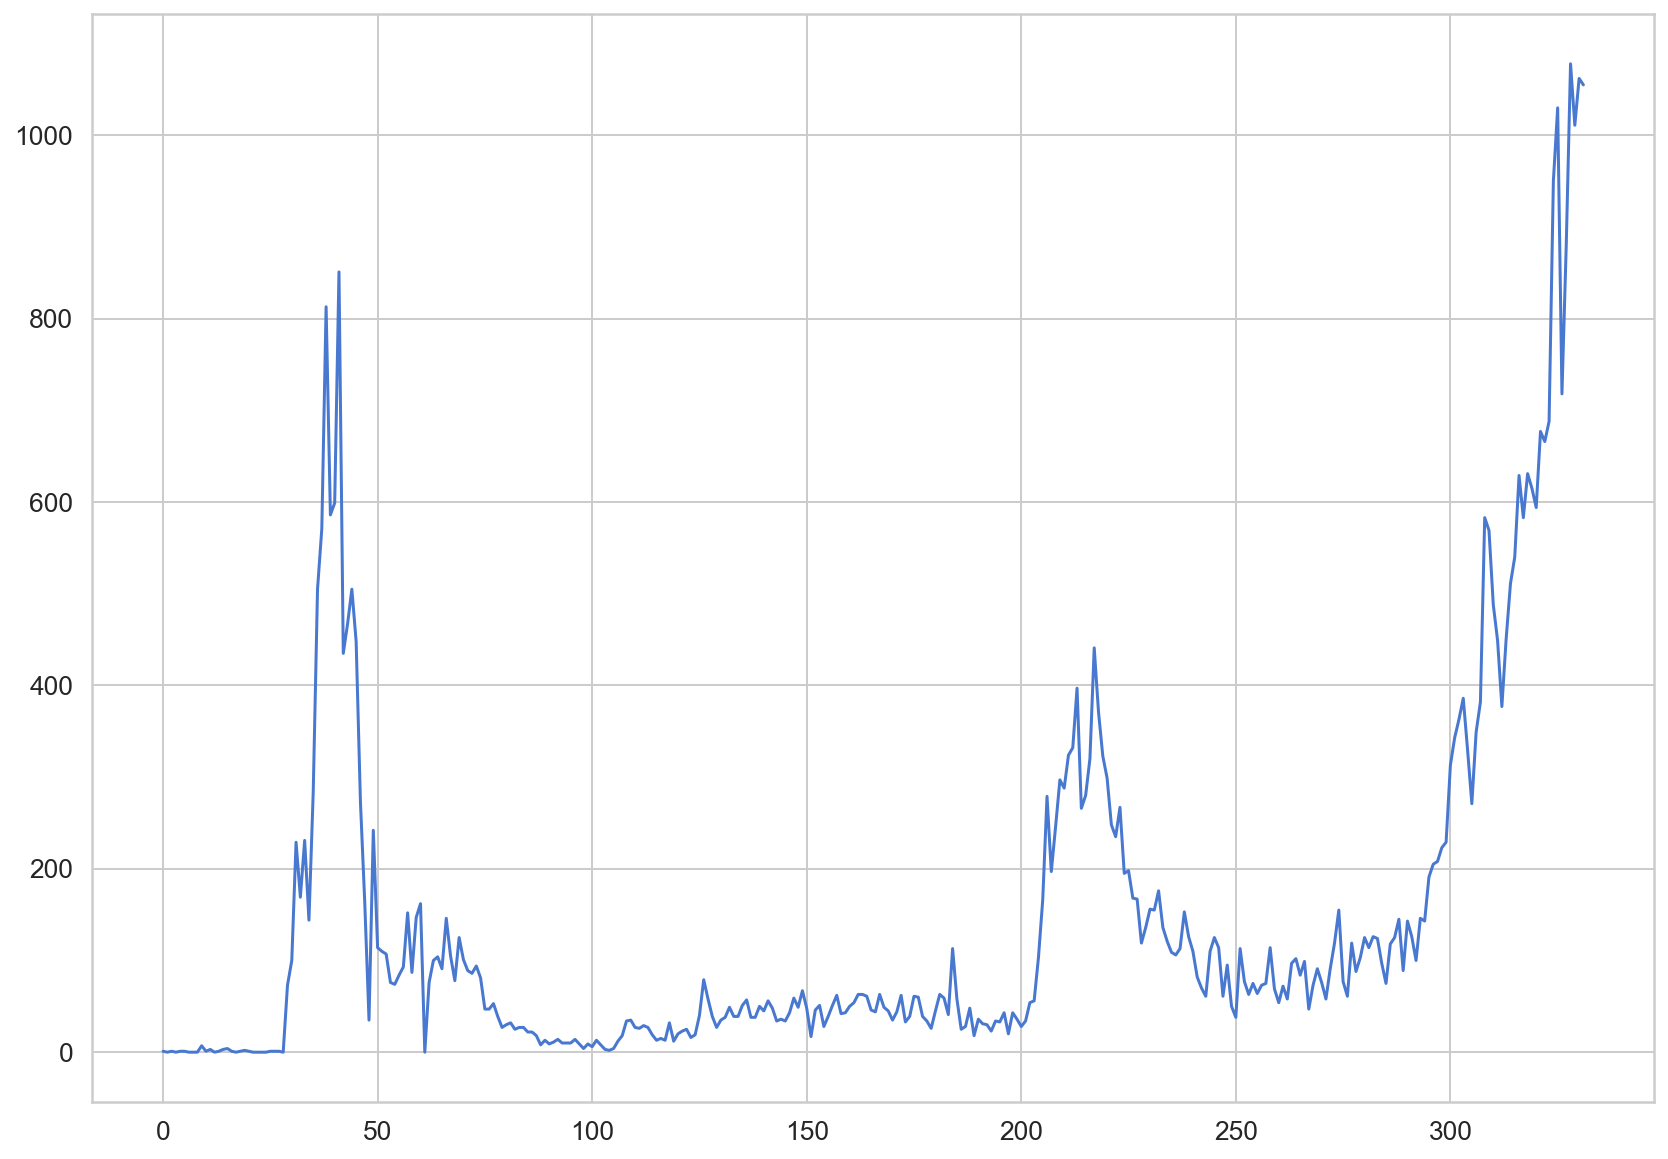

In [4]:
plt.plot(daily_cases.values)

## 5.2 CNN-LSTM 모델 정의

### 5.2.1 1D CNN (1 Dimensional Convolution Neural Network) / Conv1D

4장에서는 LSTM 모델을 이용하여 확진자 수 예측을 하였습니다. 이번 장에서는 LSTM에 CNN 레이어를 추가하여 예측을 진행해보고자 합니다.

CNN 모델은 1D, 2D, 3D로 나뉘는데, 일반적인 CNN은 보통 이미지 분류에 사용되는 2D를 통칭합니다. 여기서 D는 차원을 뜻하는 dimensional의 약자로, 인풋 데이터 형태에 따라 1D, 2D, 3D 형태의 CNN 모델이 사용됩니다.

<br>

![그림 5-1](https://github.com/Pseudo-Lab/Tutorial-Book/blob/master/book/pics/TS-ch5img01.png?raw=true)



- 그림 5-1 시계열 데이터 도식화 (출처: Understanding 1D and 3D Convolution Neural Network | Keras)

그림 5-1은 1D CNN에서 커널의 움직임을 1차적으로 시각화 한 그림입니다. 시간의 흐름에 따라 커널이 오른쪽으로 이동합니다. 시계열 데이터(Time-Series Data)를 다룰 때에는 1D CNN이 적합합니다. 1D CNN을 활용하게 되면 변수 간의 지엽적인 특징을 추출할 수 있게 됩니다.

### 5.2.2 1D CNN 테스트

![그림 5-2](https://github.com/Pseudo-Lab/Tutorial-Book/blob/master/book/pics/TS-ch5img02.png?raw=true)
![그림 5-3](https://github.com/Pseudo-Lab/Tutorial-Book/blob/master/book/pics/TS-ch5img03.png?raw=true)

- 그림 5-2 & 5-3 1D CNN 시각화

그림 5-2와 5-3은 1차원의 CNN 구조를 시각화 한 그림입니다. 그림 5-2에서 5-3으로 진행되는 것처럼, `stride`가 1일 경우 하나씩 이동한다고 보시면 됩니다. 이제 간략한 코드를 통해 1D CNN을 살펴보도록 하겠습니다.

우선 1D CNN 레어이를 정의해서 `c`에 저장합니다. 그림 5-2 & 5-3처럼 `in_channels` 1개, `out_channels` 1개, `kernel_size` 2개, `stride`는 1로 설정을 하였습니다. 그리고 나서 입력 값으로 활용할 `input`변수를 정의하고 `c`에 입력해 예측값을 산출합니다.



In [5]:
c = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1)
input = torch.Tensor([[[1,2,3,4,5]]])
output = c(input)
output

tensor([[[1.5488, 2.6763, 3.8038, 4.9313]]], grad_fn=<SqueezeBackward1>)

5개의 입력 예시들이 `kernel_size`가 2인 1D CNN을 통과하니 4개의 값이 산출됐습니다. 해당 값들이 어떻게 산출 됐는지 알아보겠습니다. 우선 `c`에 저장된 weight와 bias 값을 확인해보겠습니다.

In [6]:
for param in c.parameters():
    print(param)

Parameter containing:
tensor([[[0.5406, 0.5869]]], requires_grad=True)
Parameter containing:
tensor([-0.1657], requires_grad=True)


첫번째로 나오는 값은 weight 값을 의미합니다. `kernel_size`가 2 이므로 총 2개의 weight값이 존재합니다. 다음으로 나오는 값은 bias 값입니다. 하나의 1D CNN 레이어에 대해 하나의 bias 값이 존재합니다. 이제 해당 값들을 각각 `w1`, `w2`, `b` 변수에 저장해보겠습니다.

In [7]:
w_list = []
for param in c.parameters():
    w_list.append(param)

w = w_list[0]
b = w_list[1]

w1 = w[0][0][0]
w2 = w[0][0][1]

print(w1)
print(w2)
print(b)

tensor(0.5406, grad_fn=<SelectBackward>)
tensor(0.5869, grad_fn=<SelectBackward>)
Parameter containing:
tensor([-0.1657], requires_grad=True)


인덱싱을 통해 가중치 값들을 각각 `w1`, `w2`, `b` 변수에 저장했습니다. 그림 5-2와 5-3에서 $y1$ 과 $y2$를 산출할 때 사용한 산식을 응용하여 1D CNN을 통과했을 때의 나온 `output`값을 계산할 수 있습니다. 1D CNN 필터가 3과 4를 지날 때 산출되는 값을 계산하면 아래와 같습니다. 

In [8]:
w1 * 3 + w2 * 4 + b

tensor([3.8038], grad_fn=<AddBackward0>)

이는 `output`의 3번째 값과 같다는 것을 알 수 있으며, 나머지 값들도 이런 방식으로 계산되었음을 알 수 있습니다. 

In [9]:
output

tensor([[[1.5488, 2.6763, 3.8038, 4.9313]]], grad_fn=<SqueezeBackward1>)

## 5.3 CNN-LSTM 모델 생성

이제 CNN-LSTM 모델을 생성해보겠습니다. 4장에서 생성한 LSTM 모델과의 가장 큰 차이점은 1D CNN 레이어를 추가한 것입니다. 아래 코드를 보시면, `CovidPredictor` 클래스 안에, `nn.Conv1d`를 통해 1D CNN 레이어를 추가한 것을 확인할 수 있습니다.

In [10]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size = 2, stride = 1) # 1D CNN 레이어 추가
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden)
        )
    def forward(self, sequences):
        sequences = self.c1(sequences.view(len(sequences), 1, -1))
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len-1, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

## 5.4 모델 학습



4장에서 구축한 `train_model` 함수를 활용해 모델 학습을 해보겠습니다. 옵티마이저로는 `Adam`을 선택하였습니다. 학습비율은 `0.001`로 설정하였습니다. 손실 함수(Loss Function)로는 `MAE (Mean Absolute Error)`를 선택했습니다.

In [11]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): # sample 별 hidden state reset을 해줘야 함 

            model.reset_hidden_state()

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() #seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [12]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)

예측 모델을 간략히 살펴보도록 하겠습니다.

In [13]:
print(model)

CovidPredictor(
  (c1): Conv1d(1, 1, kernel_size=(2,), stride=(1,))
  (lstm): LSTM(1, 4)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


이제 모델 학습을 진행해보겠습니다 

In [14]:
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.08351388899966275 val loss: 0.04996650665998459
Epoch 10 train loss: 0.03722365653067399 val loss: 0.03550177812576294
Epoch 20 train loss: 0.03395552329908186 val loss: 0.03593069314956665
Epoch 30 train loss: 0.03386474570698351 val loss: 0.0337144210934639
Epoch 40 train loss: 0.03342573199924296 val loss: 0.034448377788066864
Epoch 50 train loss: 0.03347257638646297 val loss: 0.035519570112228394
Epoch 60 train loss: 0.033300402409207945 val loss: 0.034508850425481796
Epoch 70 train loss: 0.03289526019520144 val loss: 0.0338461697101593
Epoch 80 train loss: 0.03293108221917802 val loss: 0.035318538546562195
Epoch 90 train loss: 0.032627935290258106 val loss: 0.034251585602760315


시각화를 통해 훈련 손실값(Training Loss)과 시헙 손실값(Test Loss)을 살펴보겠습니다.

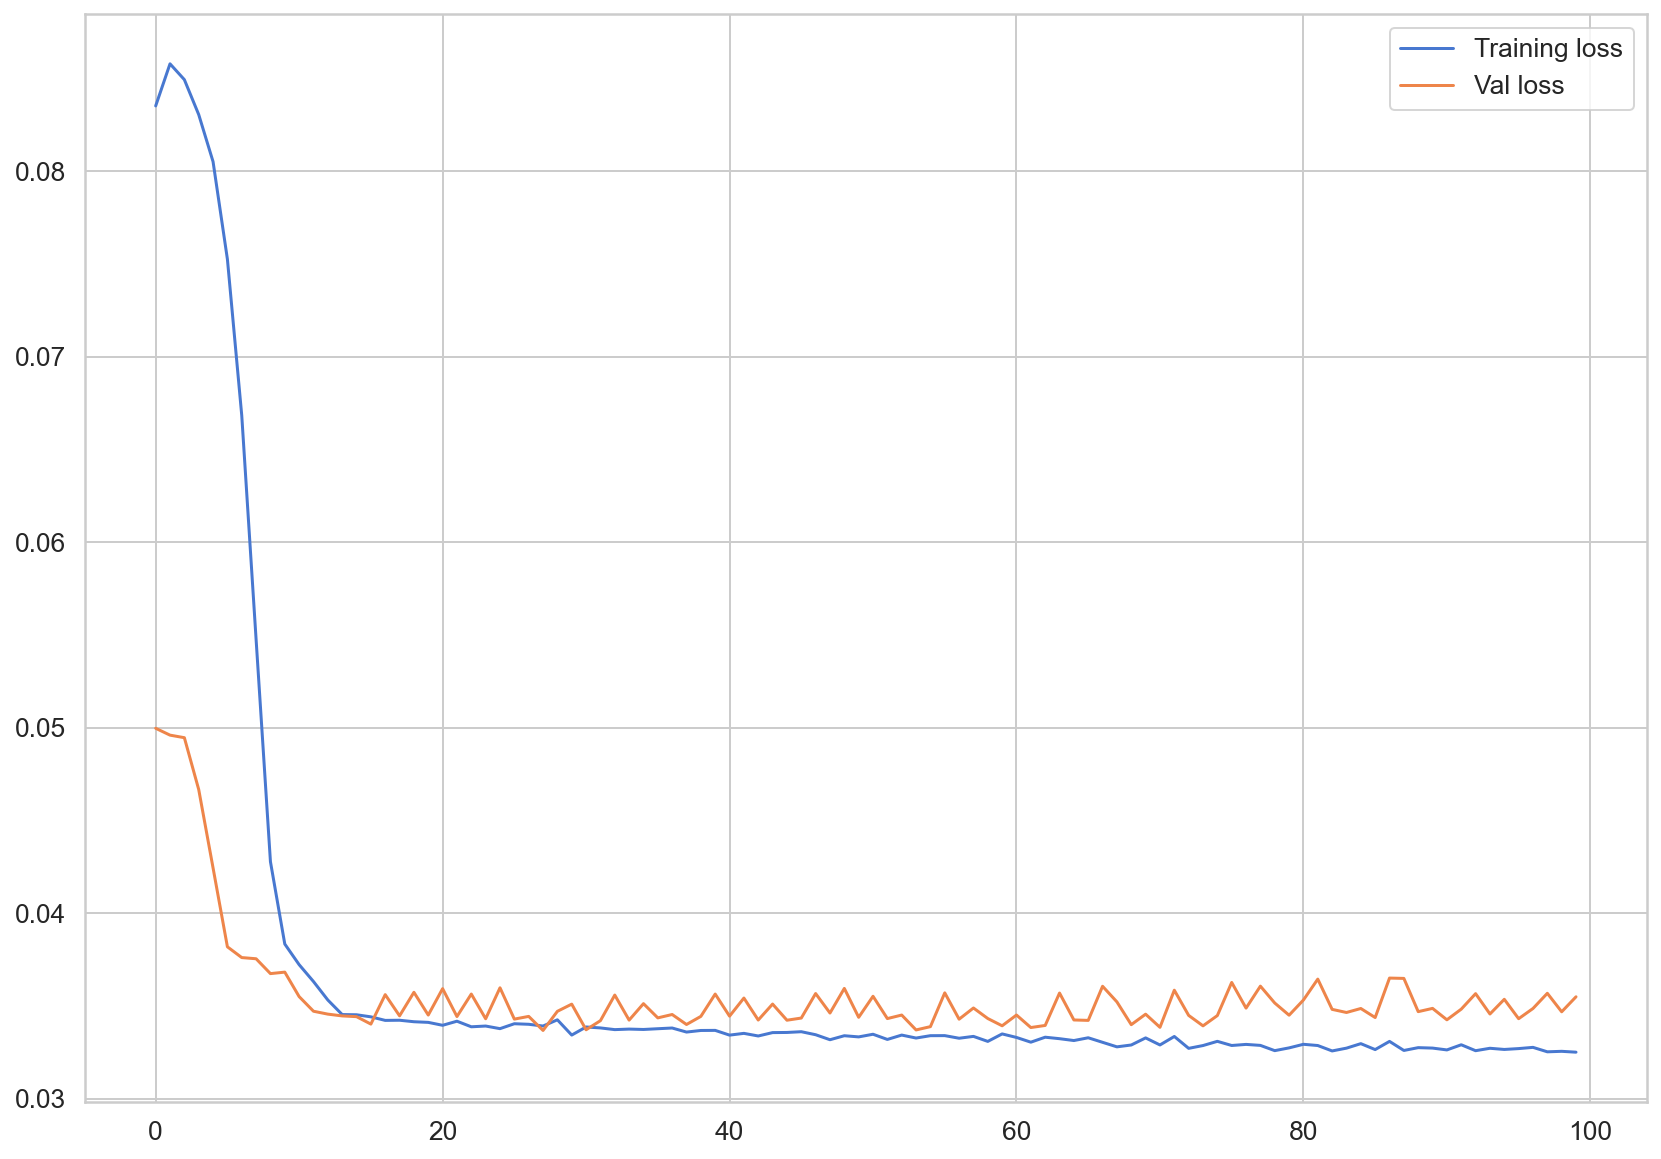

In [15]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

두 개의 손실값이 모두 수렴하는 것을 확인할 수 있습니다. 

## 5.5 확진자 수 예측

모델 학습을 마쳤으니 확진자 수 예측을 해보도록 하겠습니다. 예측할 때도 새로운 시퀀스가 입력될 때 마다 `hidden_state`는 초기화를 해줘야 이전 시퀀스의 `hidden_state`가 반영되지 않습니다. `torch.unsqueeze` 함수를 사용하여 입력 데이터의 차원을 늘려 모델이 예상하는 3차원 형태로 만들어줍니다. 그리고 예측된 데이터 내에 존재하는 스칼라값만 추출하여 `preds` 리스트에 추가합니다.

In [16]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

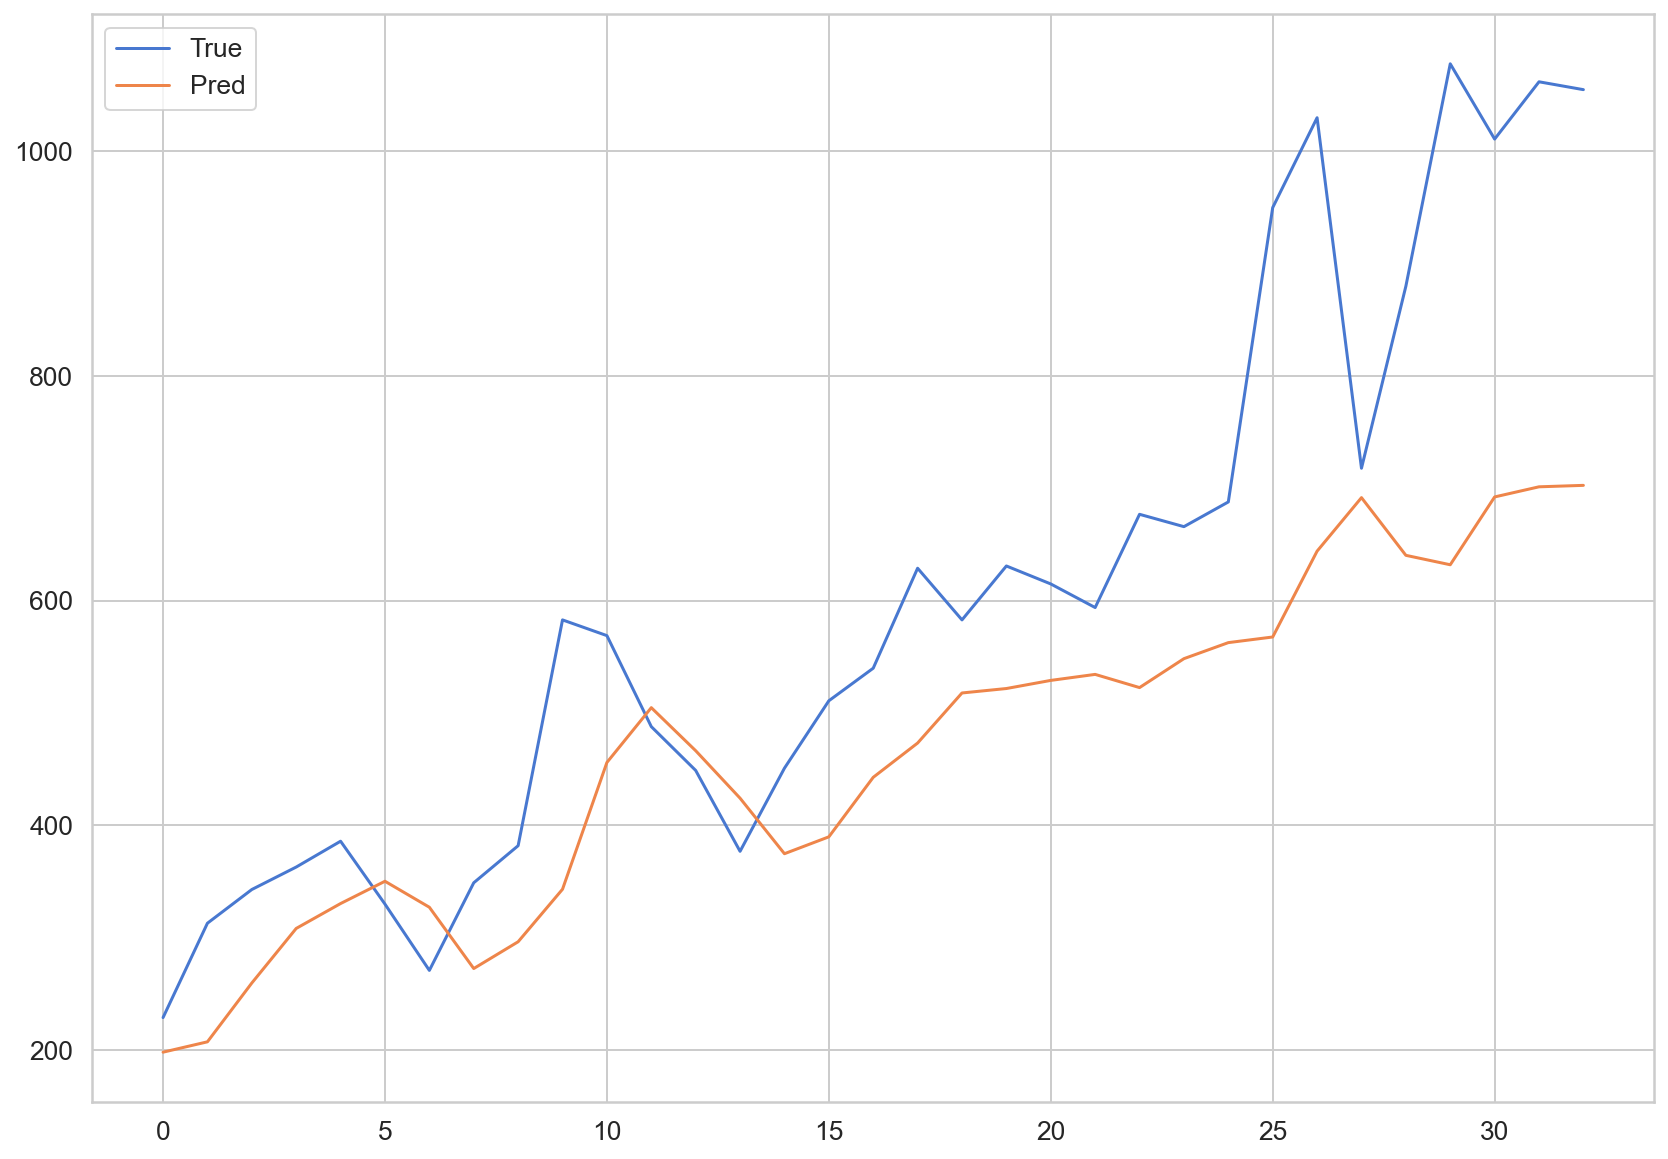

In [17]:
plt.plot(np.array(y_test)*MAX, label = 'True')
plt.plot(np.array(preds)*MAX, label = 'Pred')
plt.legend()

In [18]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [19]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)

246.46860746542612

LSTM만 사용한 모델의 MAE도 약 250이 나왔었습니다. 코로나 확진자 데이터에 대해 성능에 있어서 큰 차이는 없는 것을 확인할 수 있습니다. LSTM과 CNN-LSTM의 loss가 모두 특정 값에 수렴했기 때문이라고 볼 수 있으며, 이는 모델 구조에 비해 입력되는 데이터가 너무 간단하기 때문이라고도 볼 수 있습니다.

이상으로 코로나19 확진자 수 예측을 대한민국 데이터셋과 CNN-LSTM 모델로 실습해보았습니다. 이번 튜토리얼을 통해서 데이터셋 탐색과 데이터셋 전처리부터 시작해서 LSTM모델을 학습하고 예측을 해보았고, 더 나아가 CNN-LSTM모델도 사용해보았습니다.

시계열(Time Series) 예측은 데이터가 많지 않으면 정확도가 떨어지는게 사실입니다. 이번 튜토리얼에서는 확진자 수 데이터만 사용하여 딥러닝 모델을 학습해보습니다. 이 외에도 다양한 데이터셋을 활용하여 딥러닝 모델을 학습해보시기 바랍니다.